![title](ANTI-INFECTIVES-RGB_200pc.png)

# Abstract
We are analysing normal versus oncogene-induced senescent cells to identify putative drug targets. We are particularly interested in transmembrane protein and protein with signal peptides that are likely to be transported on the cell plasma membrane.

### ** Index: **
1. [Load Dataset](#Load-Dataset)
2. [Normalization](#Normalization)
3. [R analysis](#R-analysis)
4. [Visualise P-values](#Visualise-P-values)
5. [Differential Expression Visualisation](#Differential-Expression-Visualisation)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run external.py
import external

In [3]:
# enables the %%R magic, not necessary if you've already done this
%load_ext rpy2.ipython
%matplotlib inline

plt.style.use('ggplot')
exp_palette = ["r"]*3+["g"]*3

In [4]:
TXT_PATH = os.path.join('E:', os.sep, 'merge_old_age', '1x', 'combined', 'txt')
TXT_PATH = os.path.join('D:', os.sep,'michele','old_age','0807219','combined','txt')
#TXT_PATH = os.path.join('D:', os.sep,'michele','old_age','raw','combined','txt')
#D:\michele\old_age\raw\combined\txt

# Load-Dataset
[Return to the top](#Abstract)

In [5]:
#load the datasetD:\michele\old_age\raw\combined\txt
df = pd.read_table(os.path.join(TXT_PATH, 'proteinGroups.txt'))
df.head()

#print(df.columns)
df = df[df['Only identified by site']!='+']
print(df.shape)
df = df[df['Potential contaminant']!='+']
print(df.shape)
df = df[df['Reverse']!='+']
print(df.shape)
df['unique_pep']=[int(n.split(';')[0]) for n in df['Peptide counts (unique)']]
df = df[df['unique_pep']>=2]
print(df.shape)


#print(list(df.columns))
cols = ['Reporter intensity corrected {}'.format(n) for n in range(1,7)]
df['sum_int_corr'] = df[cols].sum(axis=1)
df = df[df['sum_int_corr']>0]

cols = ['Reporter intensity {}'.format(n) for n in range(1,7)]
df['sum_int'] = df[cols].sum(axis=1)
df = df[df['sum_int']>0]


print(df.shape)

data=df[cols]
data.columns = ['S1', 'S2', 'S3', 'C1', 'C2', 'C3']
#(9776, 82)
#(9240, 82)
#(9240, 83)
#(9109, 85)

(8818, 100)
(8725, 100)
(8640, 100)
(7500, 101)
(7496, 103)


In [6]:
df['Sequence coverage [%]'].median(),df['Peptides'].median(),df['Unique peptides'].median()

(24.5, 9.0, 8.0)

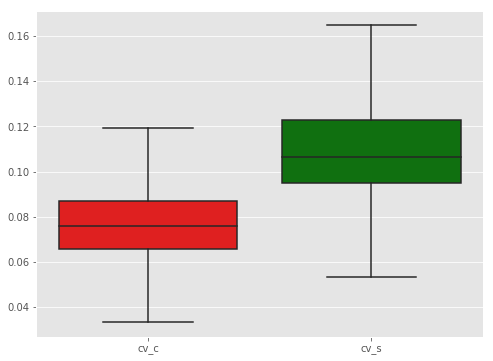

In [86]:
cv = data.copy()
cv = cv.dropna()
cv['mean_c'] = cv[['C1','C2','C3']].mean(axis=1)
cv['std_c'] = cv[['C1','C2','C3']].std(axis=1)
cv['mean_s'] = cv[['S1','S2','S3']].mean(axis=1)
cv['std_s'] = cv[['S1','S2','S3']].std(axis=1)
cv['cv_c'] = cv['std_c']/cv['mean_c']
cv['cv_s'] = cv['std_s']/cv['mean_s']
fig,ax=plt.subplots(figsize=(8,6))
sns.boxplot(data=cv[['cv_c','cv_s']],palette=['r','g'],
            showfliers=False,ax=ax)
plt.savefig(os.path.join(TXT_PATH,'Fig_S3A_cv.png'))
plt.show()

# Normalization
[Return to the top](#Abstract)

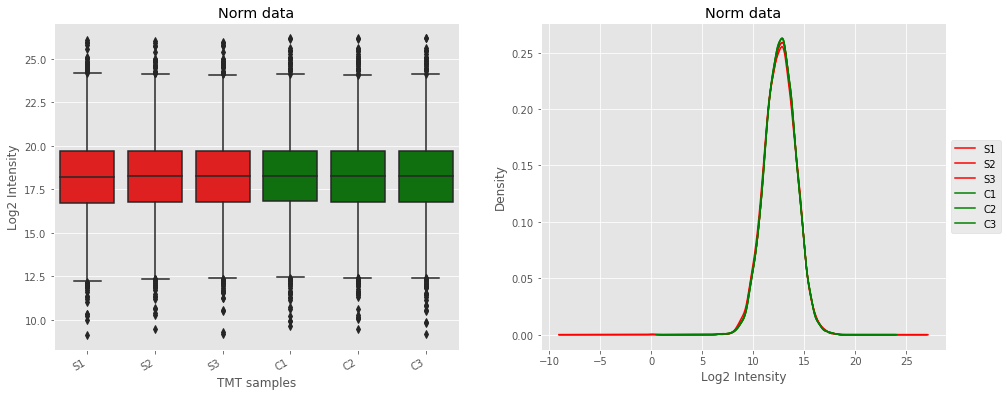

In [7]:
#we create normalization factors based on the average sum intensity of each channel
col_sum = data.sum(axis=0)
target = np.mean(col_sum)
norm_facs = target / col_sum
data_norm = data.multiply(norm_facs, axis=1)


fig,axes=plt.subplots(figsize=(16,6),ncols=2,nrows=1)
sns.boxplot(data=np.log2(data_norm), ax=axes[0],palette=exp_palette)
axes[0].set_xticklabels(data.columns, rotation=30, ha='right')
axes[0].set_title('Norm data')
axes[0].set_xlabel('TMT samples')
axes[0].set_ylabel('Log2 Intensity')
plt.ylabel('log2 of intensity')

np.log1p(data_norm).plot(kind='kde',ax=axes[1],color=exp_palette)
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].set_title('Norm data')
axes[1].set_xlabel('Log2 Intensity')
plt.savefig(os.path.join(TXT_PATH,'Fig_S1_intensity_distribution.png'))
plt.show()

[0.9646927  0.03355281]


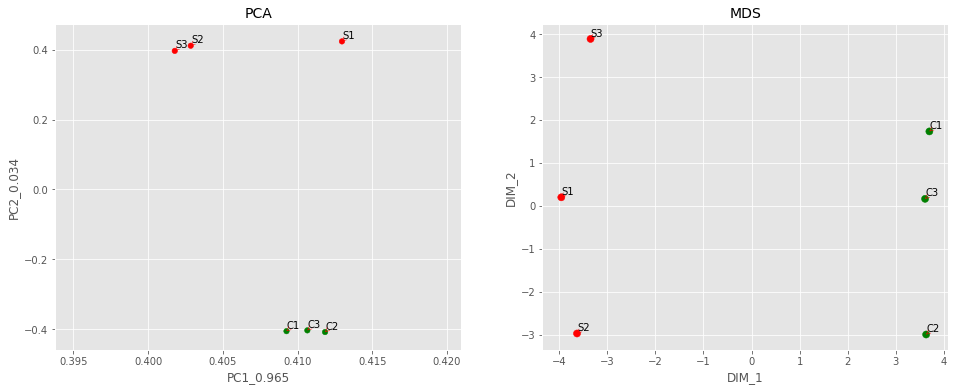

In [8]:
fig,axes=plt.subplots(figsize=(16,6), ncols=2,nrows=1)
external.make_pca(np.log2(data), exp_palette, ax=axes[0])
external.make_mds(np.log2(data), exp_palette, ax=axes[1])
plt.savefig(os.path.join(TXT_PATH,'Fig_S2_pca.png'))
plt.show()

In [9]:
df['Gene names']=['_'.join(n.split(';')[0].split(' ')[0].split('|')[1:]) for n in df['Fasta headers']]
data_norm['genes'] = data_norm.index.map(df['Gene names'])
data_norm['genes']=[str(n).split(';')[0] for n in data_norm['genes']]
data_norm['genes']=[str(n[0])+'_'+str(n[1]) for n in zip(data_norm.index.values,data_norm['genes'])]
data_norm.head()

,S1,S2,S3,C1,C2,C3,genes
102,8.533728e+05,1.258813e+06,1.296349e+06,1.055009e+06,1.055663e+06,1.059123e+06,102_ENST00000373020_O43657__TSPAN6
103,1.059605e+06,1.194595e+06,1.169123e+06,1.085101e+06,1.083927e+06,1.085784e+06,103_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1
104,7.430159e+04,8.278515e+04,8.399583e+04,8.170924e+04,8.044888e+04,7.892759e+04,104_ENST00000423670__X6RHX1_SCYL3
105,5.509498e+05,6.037470e+05,6.187099e+05,7.490698e+05,7.757707e+05,7.453153e+05,105_ENST00000002165_Q9BTY2__FUCA2
106,1.028362e+06,1.271489e+06,1.301303e+06,1.087941e+06,1.091924e+06,1.083078e+06,106_ENST00000650454_P48506_Q14TF0_GCLC


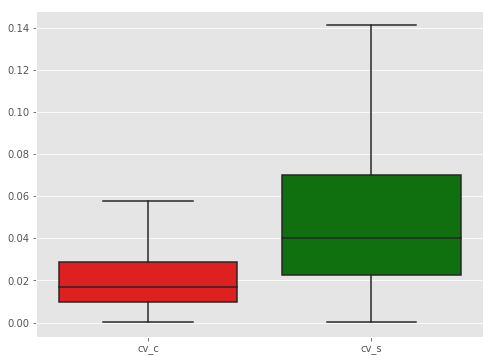

In [10]:
cv = data_norm.copy()
cv = cv.dropna()
cv['mean_c'] = cv[['C1','C2','C3']].mean(axis=1)
cv['std_c'] = cv[['C1','C2','C3']].std(axis=1)
cv['mean_s'] = cv[['S1','S2','S3']].mean(axis=1)
cv['std_s'] = cv[['S1','S2','S3']].std(axis=1)
cv['cv_c'] = cv['std_c']/cv['mean_c']
cv['cv_s'] = cv['std_s']/cv['mean_s']
fig,ax=plt.subplots(figsize=(8,6))
sns.boxplot(data=cv[['cv_c','cv_s']],palette=['r','g'],
            showfliers=False,ax=ax)
plt.savefig(os.path.join(TXT_PATH,'Fig_S3B_cv.png'))
plt.show()

# R analysis
[Return to the top](#Abstract)

In [11]:
%%R -i data_norm
options(warn=-1)
library("tidyverse")
library("psych")
library("gridExtra")
library("scales")
library("limma") 
library("edgeR")

In [12]:
%%R
accession <- data_norm$'genes'
limma_data = within(data_norm, rm('genes'))

In [13]:
%R head(limma_data)

,S1,S2,S3,C1,C2,C3
102,8.533728e+05,1.258813e+06,1.296349e+06,1.055009e+06,1.055663e+06,1.059123e+06
103,1.059605e+06,1.194595e+06,1.169123e+06,1.085101e+06,1.083927e+06,1.085784e+06
104,7.430159e+04,8.278515e+04,8.399583e+04,8.170924e+04,8.044888e+04,7.892759e+04
105,5.509498e+05,6.037470e+05,6.187099e+05,7.490698e+05,7.757707e+05,7.453153e+05
106,1.028362e+06,1.271489e+06,1.301303e+06,1.087941e+06,1.091924e+06,1.083078e+06
107,7.684477e+05,7.761166e+05,7.737786e+05,6.966824e+05,6.794378e+05,6.692713e+05


In [14]:
%%R
row.names(limma_data) <- accession # add accessions as row names
# set up the design matrix
group <- as.factor(c(rep("senescent", 3), rep("control", 3)))
group <- factor(group, levels(group)[c(2, 1)]) # set the factor order
design <- model.matrix(~ 0 + group)
colnames(design) <- c("senescent", "control")

# make the contrast
contrast <- makeContrasts(senescent-control, levels = design)

S <- 1:3
C <- 4:6
# do the linear model fitting on log2 values
limma_log_data <- log2(limma_data[c(S, C)])
fit <- lmFit(limma_log_data, design)

# get the fit for the contrast of interest
fit2 <- contrasts.fit(fit, contrast)

# do the empirical Bayes moderation of the test statistic (with trended variance)
fit2 <- eBayes(fit2, trend = TRUE)

# grab the information in topTable so we can get the data to plot candidates
# the coef parameter has to do with the contrast of interest
# specify no sorting of results and a number that is longer than the data table
tt_limma <- topTable(fit2, coef = 1, sort.by = "none", number = Inf)


In [15]:
#check
#%R -o design
#print(design)
#%R design

In [16]:
# let's see how many up and down candidates, and the top tags
%R topTable(fit2)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
403_ENST00000037243_P60520__GABARAPL2,-1.344993,19.559780,-71.400508,9.618003e-11,2.243042e-07,15.544355
2505_ENST00000456829_O00534_A0A024R3H3_VWA5A,1.205600,21.532479,66.852930,1.481178e-10,2.243042e-07,15.180970
6296_ENST00000290573_P52789__HK2,1.149612,20.446966,64.834247,1.811192e-10,2.243042e-07,15.007383
2679_ENST00000419835__J3KQ69_MCM3,-1.496987,17.974257,-63.178655,2.146140e-10,2.243042e-07,14.858904
662_ENST00000565096__B4DDF4_CNN2,-0.935912,21.638812,-61.107132,2.670704e-10,2.243042e-07,14.664887
4412_ENST00000257290_P16234__PDGFRA,-1.066999,20.570413,-61.073451,2.680380e-10,2.243042e-07,14.661654
3492_ENST00000372764_P00749__PLAU,1.120382,20.356346,60.988836,2.704865e-10,2.243042e-07,14.653520
274_ENST00000552962_P07585_Q6FH10_DCN,-1.290901,18.774078,-60.248435,2.930467e-10,2.243042e-07,14.581646
6799_ENST00000620463__A0A087WTA8_COL1A2,-0.969931,21.304457,-59.054347,3.341604e-10,2.243042e-07,14.463026
8373_ENST00000395564_Q16831__UPP1,1.490818,18.881452,58.342817,3.618093e-10,2.243042e-07,14.390709


In [17]:
#%%R
#limma_data$ave_med <- rowMeans(limma_data[S])
#limma_data$ave_exo  <- rowMeans(limma_data[C])
#limma_data$logFC <- log2(limma_data$ave_exo / limma_data$ave_med)
#limma_data$FC <- ifelse(limma_data$ave_exo > limma_data$ave_med, 
                          #(limma_data$ave_exo / limma_data$ave_med), 
                          #(-1 * limma_data$ave_med / limma_data$ave_exo))


In [18]:
%%R
# statisticl test results
limma_data$Acc <- accession
limma_data$PValue <- tt_limma$P.Value
limma_data$FDR <- tt_limma$adj.P.Val
head(limma_data)
# add a DE candidate status column
limma_data$candidate <- cut(limma_data$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                           labels = c("high", "med", "low", "no"))


In [19]:
%R head(limma_data)

,S1,S2,S3,C1,C2,C3,Acc,PValue,FDR,candidate
102_ENST00000373020_O43657__TSPAN6,8.533728e+05,1.258813e+06,1.296349e+06,1.055009e+06,1.055663e+06,1.059123e+06,102_ENST00000373020_O43657__TSPAN6,0.618107,0.666770,no
103_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,1.059605e+06,1.194595e+06,1.169123e+06,1.085101e+06,1.083927e+06,1.085784e+06,103_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.160452,0.203621,no
104_ENST00000423670__X6RHX1_SCYL3,7.430159e+04,8.278515e+04,8.399583e+04,8.170924e+04,8.044888e+04,7.892759e+04,104_ENST00000423670__X6RHX1_SCYL3,0.972037,0.977252,no
105_ENST00000002165_Q9BTY2__FUCA2,5.509498e+05,6.037470e+05,6.187099e+05,7.490698e+05,7.757707e+05,7.453153e+05,105_ENST00000002165_Q9BTY2__FUCA2,0.000152,0.000526,high
106_ENST00000650454_P48506_Q14TF0_GCLC,1.028362e+06,1.271489e+06,1.301303e+06,1.087941e+06,1.091924e+06,1.083078e+06,106_ENST00000650454_P48506_Q14TF0_GCLC,0.164850,0.208356,no
107_ENST00000374807_Q9Y4W2__LAS1L,7.684477e+05,7.761166e+05,7.737786e+05,6.966824e+05,6.794378e+05,6.692713e+05,107_ENST00000374807_Q9Y4W2__LAS1L,0.000129,0.000461,high


In [20]:
# count candidates
print("Candidate Counts:")
%R summary(limma_data$candidate)

Candidate Counts:


array([3920, 1008,  465, 2102,    1], dtype=int32)

In [21]:
%R -o limma_data

In [22]:
limma_data.head()

,S1,S2,S3,C1,C2,C3,Acc,PValue,FDR,candidate
102_ENST00000373020_O43657__TSPAN6,8.533728e+05,1.258813e+06,1.296349e+06,1.055009e+06,1.055663e+06,1.059123e+06,102_ENST00000373020_O43657__TSPAN6,0.618107,0.666770,no
103_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,1.059605e+06,1.194595e+06,1.169123e+06,1.085101e+06,1.083927e+06,1.085784e+06,103_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.160452,0.203621,no
104_ENST00000423670__X6RHX1_SCYL3,7.430159e+04,8.278515e+04,8.399583e+04,8.170924e+04,8.044888e+04,7.892759e+04,104_ENST00000423670__X6RHX1_SCYL3,0.972037,0.977252,no
105_ENST00000002165_Q9BTY2__FUCA2,5.509498e+05,6.037470e+05,6.187099e+05,7.490698e+05,7.757707e+05,7.453153e+05,105_ENST00000002165_Q9BTY2__FUCA2,0.000152,0.000526,high
106_ENST00000650454_P48506_Q14TF0_GCLC,1.028362e+06,1.271489e+06,1.301303e+06,1.087941e+06,1.091924e+06,1.083078e+06,106_ENST00000650454_P48506_Q14TF0_GCLC,0.164850,0.208356,no


In [23]:
#clean R name space
%R rm(list=ls())

In [24]:
#data_def.head()

# Visualise P-values
[Return to the top](#Abstract)

In [25]:
to_drop = ['S1','S2','S3','C1','C2','C3']
limma_data.drop(to_drop,axis=1,inplace=True)
print(data_norm.shape)
data_def = limma_data.join(data_norm.set_index('genes'))
print(data_def.shape)
data_def.head()

(7496, 7)
(7496, 10)


,Acc,PValue,FDR,candidate,S1,S2,S3,C1,C2,C3
102_ENST00000373020_O43657__TSPAN6,102_ENST00000373020_O43657__TSPAN6,0.618107,0.666770,no,8.533728e+05,1.258813e+06,1.296349e+06,1.055009e+06,1.055663e+06,1.059123e+06
103_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,103_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.160452,0.203621,no,1.059605e+06,1.194595e+06,1.169123e+06,1.085101e+06,1.083927e+06,1.085784e+06
104_ENST00000423670__X6RHX1_SCYL3,104_ENST00000423670__X6RHX1_SCYL3,0.972037,0.977252,no,7.430159e+04,8.278515e+04,8.399583e+04,8.170924e+04,8.044888e+04,7.892759e+04
105_ENST00000002165_Q9BTY2__FUCA2,105_ENST00000002165_Q9BTY2__FUCA2,0.000152,0.000526,high,5.509498e+05,6.037470e+05,6.187099e+05,7.490698e+05,7.757707e+05,7.453153e+05
106_ENST00000650454_P48506_Q14TF0_GCLC,106_ENST00000650454_P48506_Q14TF0_GCLC,0.164850,0.208356,no,1.028362e+06,1.271489e+06,1.301303e+06,1.087941e+06,1.091924e+06,1.083078e+06


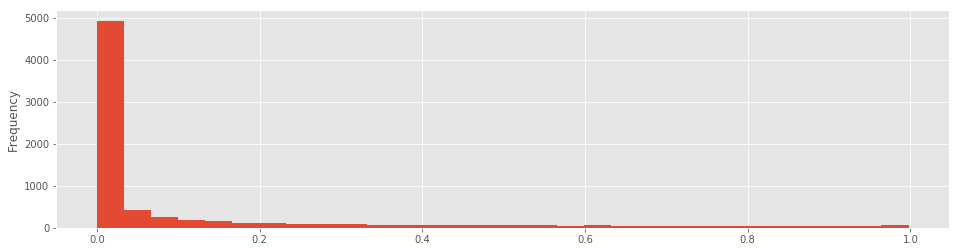

In [26]:
data_def.PValue.plot(kind='hist', bins=30,figsize=(16,4))
plt.savefig(os.path.join(TXT_PATH,'Fig_S4_pval.png'))
plt.show()

# Differential Expression Visualisation
[Return to the top](#Abstract)

In [27]:
#add some values for plotting results
data_def['mean_s'] = data_def[['S1','S2','S3']].mean(axis=1)
data_def['mean_c'] = data_def[['C1','C2','C3']].mean(axis=1)
data_def['Log2FC'] = np.log2(data_def['mean_c']/data_def['mean_s'])
data_def['Log10signal'] = np.log10(data_def['mean_c']+data_def['mean_s'])
data_def['-Log10PValue'] = -np.log10(data_def['PValue'])
data_def['Log10signal_Q'] = pd.qcut(data_def['Log10signal'], 50, range(50))

In [28]:
print(data_def.shape)
data_def['index']=[int(n.split('_')[0]) for n in data_def['Acc']]
data_def=data_def.set_index('index',drop=True)

(7496, 16)


In [29]:
print(data_def.shape)
data_def.head()

(7496, 16)


,Acc,PValue,FDR,candidate,S1,S2,S3,C1,C2,C3,mean_s,mean_c,Log2FC,Log10signal,-Log10PValue,Log10signal_Q
index,,,,,,,,,,,,,,,,
102,102_ENST00000373020_O43657__TSPAN6,0.618107,0.666770,no,8.533728e+05,1.258813e+06,1.296349e+06,1.055009e+06,1.055663e+06,1.059123e+06,1.136178e+06,1.056598e+06,-0.104762,6.340994,0.208936,39
103,103_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.160452,0.203621,no,1.059605e+06,1.194595e+06,1.169123e+06,1.085101e+06,1.083927e+06,1.085784e+06,1.141108e+06,1.084937e+06,-0.072823,6.347534,0.794656,40
104,104_ENST00000423670__X6RHX1_SCYL3,0.972037,0.977252,no,7.430159e+04,8.278515e+04,8.399583e+04,8.170924e+04,8.044888e+04,7.892759e+04,8.036086e+04,8.036190e+04,0.000019,5.206077,0.012317,9
105,105_ENST00000002165_Q9BTY2__FUCA2,0.000152,0.000526,high,5.509498e+05,6.037470e+05,6.187099e+05,7.490698e+05,7.757707e+05,7.453153e+05,5.911355e+05,7.567186e+05,0.356268,6.129643,3.818127,34
106,106_ENST00000650454_P48506_Q14TF0_GCLC,0.164850,0.208356,no,1.028362e+06,1.271489e+06,1.301303e+06,1.087941e+06,1.091924e+06,1.083078e+06,1.200385e+06,1.087648e+06,-0.142285,6.359462,0.782911,40


In [30]:
histones = [
'ENSG00000124575','HIST1H1D','H1D','H1',
'ENSG00000124610','HIST1H1A','H1A','H1',
'ENSG00000124635','HIST1H2BJ','H2BJ','Core',
'ENSG00000278705','HIST1H4B','H4B','Core',
'ENSG00000168298','HIST1H1E','H1E','H1',
'ENSG00000276368','HIST1H2AJ','H2AJ','Core',
'ENSG00000284841','HIST3H2A','H2A','Core',
'ENSG00000203852','HIST2H3A','H3A','Core',
'ENSG00000184270','HIST2H2AB','H2AB','Core',
'ENSG00000184357','HIST1H1B','H1B','H1',
'ENSG00000276410','HIST1H2BB','H2BB','Core',
'ENSG00000185130','HIST1H2BL','H2BL','Core',
'ENSG00000187837','HIST1H1C','H1C','H1',
'ENSG00000278828','HIST1H3H','H3H','Core',
'ENSG00000203814','HIST2H2BF','H2BF','Core',
'ENSG00000203818','HIST2H3PS2','H3PS2','Core',
'ENSG00000184897','H1FX','H1FX','H1',
'ENSG00000189060','H1F0','H1F0','H1',
'ENSG00000149948','HMGA2','HMGA2','H1']
len(histones)/4
histones_df = pd.DataFrame()
histones_df['genes']=[n for index,n in enumerate(histones) if index%4==0]
histones_df['names']=[n for index,n in enumerate(histones[1:]) if index%4==0]
histones_df['short_name']=[n for index,n in enumerate(histones[2:]) if index%4==0]
histones_df['class']=[n for index,n in enumerate(histones[3:]) if index%4==0]

In [31]:
print(data_def.shape)
data_def.head()

(7496, 16)


,Acc,PValue,FDR,candidate,S1,S2,S3,C1,C2,C3,mean_s,mean_c,Log2FC,Log10signal,-Log10PValue,Log10signal_Q
index,,,,,,,,,,,,,,,,
102,102_ENST00000373020_O43657__TSPAN6,0.618107,0.666770,no,8.533728e+05,1.258813e+06,1.296349e+06,1.055009e+06,1.055663e+06,1.059123e+06,1.136178e+06,1.056598e+06,-0.104762,6.340994,0.208936,39
103,103_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.160452,0.203621,no,1.059605e+06,1.194595e+06,1.169123e+06,1.085101e+06,1.083927e+06,1.085784e+06,1.141108e+06,1.084937e+06,-0.072823,6.347534,0.794656,40
104,104_ENST00000423670__X6RHX1_SCYL3,0.972037,0.977252,no,7.430159e+04,8.278515e+04,8.399583e+04,8.170924e+04,8.044888e+04,7.892759e+04,8.036086e+04,8.036190e+04,0.000019,5.206077,0.012317,9
105,105_ENST00000002165_Q9BTY2__FUCA2,0.000152,0.000526,high,5.509498e+05,6.037470e+05,6.187099e+05,7.490698e+05,7.757707e+05,7.453153e+05,5.911355e+05,7.567186e+05,0.356268,6.129643,3.818127,34
106,106_ENST00000650454_P48506_Q14TF0_GCLC,0.164850,0.208356,no,1.028362e+06,1.271489e+06,1.301303e+06,1.087941e+06,1.091924e+06,1.083078e+06,1.200385e+06,1.087648e+06,-0.142285,6.359462,0.782911,40


## With Histones

In [32]:
histones_df.head()

,genes,names,short_name,class
0,ENSG00000124575,HIST1H1D,H1D,H1
1,ENSG00000124610,HIST1H1A,H1A,H1
2,ENSG00000124635,HIST1H2BJ,H2BJ,Core
3,ENSG00000278705,HIST1H4B,H4B,Core
4,ENSG00000168298,HIST1H1E,H1E,H1


In [33]:
#df['Fasta headers'].head()
#df[df['Fasta headers'].str.c('00000276368')]

In [34]:
data_def.head()

,Acc,PValue,FDR,candidate,S1,S2,S3,C1,C2,C3,mean_s,mean_c,Log2FC,Log10signal,-Log10PValue,Log10signal_Q
index,,,,,,,,,,,,,,,,
102,102_ENST00000373020_O43657__TSPAN6,0.618107,0.666770,no,8.533728e+05,1.258813e+06,1.296349e+06,1.055009e+06,1.055663e+06,1.059123e+06,1.136178e+06,1.056598e+06,-0.104762,6.340994,0.208936,39
103,103_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.160452,0.203621,no,1.059605e+06,1.194595e+06,1.169123e+06,1.085101e+06,1.083927e+06,1.085784e+06,1.141108e+06,1.084937e+06,-0.072823,6.347534,0.794656,40
104,104_ENST00000423670__X6RHX1_SCYL3,0.972037,0.977252,no,7.430159e+04,8.278515e+04,8.399583e+04,8.170924e+04,8.044888e+04,7.892759e+04,8.036086e+04,8.036190e+04,0.000019,5.206077,0.012317,9
105,105_ENST00000002165_Q9BTY2__FUCA2,0.000152,0.000526,high,5.509498e+05,6.037470e+05,6.187099e+05,7.490698e+05,7.757707e+05,7.453153e+05,5.911355e+05,7.567186e+05,0.356268,6.129643,3.818127,34
106,106_ENST00000650454_P48506_Q14TF0_GCLC,0.164850,0.208356,no,1.028362e+06,1.271489e+06,1.301303e+06,1.087941e+06,1.091924e+06,1.083078e+06,1.200385e+06,1.087648e+06,-0.142285,6.359462,0.782911,40


In [35]:
#add histone index
_ids = []
_names = []
for gene_id, gene_name in zip(histones_df['genes'],histones_df['names']):
    res_ids =list(df[df['Fasta headers'].str.contains(gene_id)].index.values)
    if len(res_ids)>0:
        _ids+=res_ids
        _names += [gene_name]*len(res_ids)
print(len(_ids))
print(len(_names))

10
10


In [36]:
#histones_ids

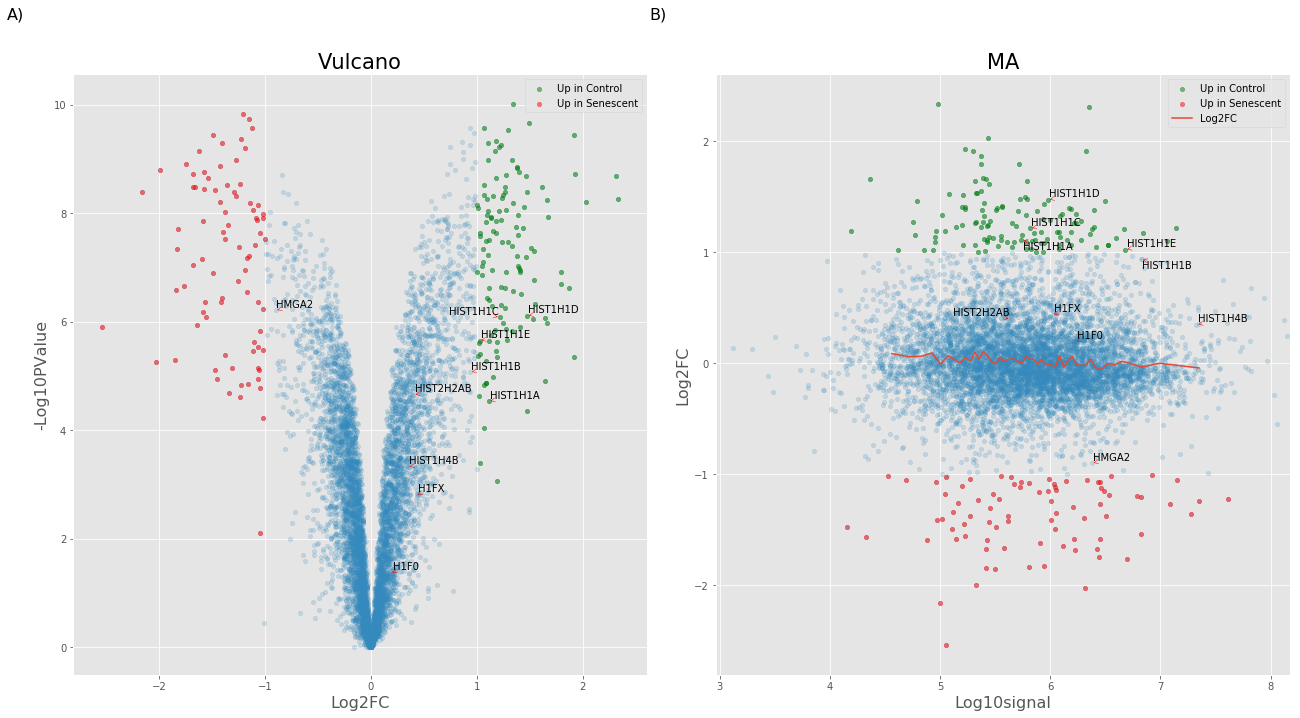

In [37]:
fig,axes=plt.subplots(figsize=(18,10), ncols=2, nrows=1)

make_vulcano(data_def, axes[0], x='Log2FC',y='-Log10PValue', 
             annot_index=_ids,
             annot_names = _names,
             title='Vulcano')

make_vulcano(data_def, axes[1], x='Log10signal', y='Log2FC', 
             annot_index=_ids,
             annot_names = _names,
             title='MA')

data_def.groupby('Log10signal_Q')[['Log10signal','Log2FC']].mean().plot(ax=axes[1],
                                                                        x='Log10signal',
                                                                        y='Log2FC')

axes[1].set_xlim(data_def['Log10signal'].min()-data_def['Log10signal'].min()*0.01,
                 data_def['Log10signal'].max()+data_def['Log10signal'].min()*0.01)

axes[0].title.set_size(21)
axes[1].title.set_size(21)
axes[0].yaxis.label.set_size(16)
axes[0].xaxis.label.set_size(16)
axes[1].yaxis.label.set_size(16)
axes[1].xaxis.label.set_size(16)
axes[0].text(-0.1, 1.1, 'A)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[0].transAxes,fontsize=16)

axes[1].text(-0.1, 1.1, 'B)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[1].transAxes,fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(TXT_PATH,'Fig_1_Histones.png'))
plt.show()

## With cyclin

In [38]:
cdks = [
'ENSG00000058091','CDK14',
'ENSG00000059758','CDK17',
'ENSG00000065883','CDK13',
'ENSG00000101391','CDK5RAP1',
'ENSG00000102225','CDK16',
'ENSG00000105810','CDK6',
'ENSG00000108465','CDK5RAP3',
'ENSG00000111276','CDKN1B',
'ENSG00000111328','CDK2AP1',
'ENSG00000123374','CDK2',
'ENSG00000124762','CDKN1A',
'ENSG00000147889','CDKN2A',    
'ENSG00000273707','CDKN1C',
'ENSG00000132964','CDK8',
'ENSG00000134058','CDK7',
'ENSG00000135446','CDK4',
'ENSG00000136807','CDK9',
'ENSG00000136861','CDK5RAP2',
'ENSG00000145996','CDKAL1',
'ENSG00000155111','CDK19',
'ENSG00000163482','STK36',
'ENSG00000164885','CDK5',
'ENSG00000167258','CDK12',
'ENSG00000168564','CDKN2AIP',
'ENSG00000185324','CDK10',
'ENSG00000248333','CDK11B']
cdks_df = pd.DataFrame()
cdks_df['genes']=[n for index,n in enumerate(cdks) if index%2==0]
cdks_df['names']=[n for index,n in enumerate(cdks[1:]) if index%2==0]

_ids = []
_names = []
for gene_id, gene_name in zip(cdks_df['genes'],cdks_df['names']):
    res_ids =list(df[df['Fasta headers'].str.contains(gene_id)].index.values)
    if len(res_ids)>0:
        _ids+=res_ids
        _names += [gene_name]*len(res_ids)
print(len(_ids))
print(len(_names))

20
20


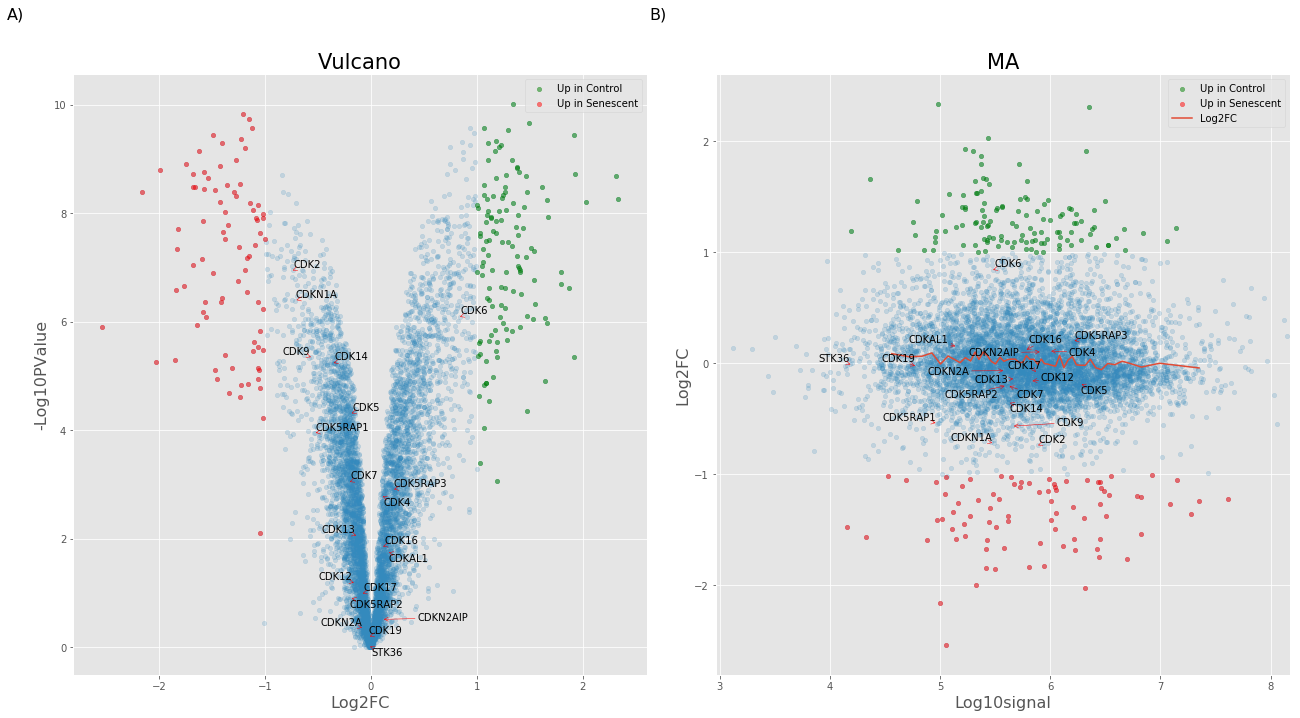

In [39]:
fig,axes=plt.subplots(figsize=(18,10), ncols=2, nrows=1)

make_vulcano(data_def, axes[0], x='Log2FC',y='-Log10PValue', 
             annot_index=_ids,
             annot_names = _names,
             title='Vulcano')

make_vulcano(data_def, axes[1], x='Log10signal', y='Log2FC', 
             annot_index=_ids,
             annot_names = _names,
             title='MA')

data_def.groupby('Log10signal_Q')[['Log10signal','Log2FC']].mean().plot(ax=axes[1],
                                                                        x='Log10signal',
                                                                        y='Log2FC')

axes[1].set_xlim(data_def['Log10signal'].min()-data_def['Log10signal'].min()*0.01,
                 data_def['Log10signal'].max()+data_def['Log10signal'].min()*0.01)

axes[0].title.set_size(21)
axes[1].title.set_size(21)
axes[0].yaxis.label.set_size(16)
axes[0].xaxis.label.set_size(16)
axes[1].yaxis.label.set_size(16)
axes[1].xaxis.label.set_size(16)
axes[0].text(-0.1, 1.1, 'A)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[0].transAxes,fontsize=16)

axes[1].text(-0.1, 1.1, 'B)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[1].transAxes,fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(TXT_PATH,'Fig_2_cyclins.png'))
plt.show()

## With Senecent Markers

In [40]:
#PMID: 25412306
#Characterization of novel markers of senescence 
#and their prognostic potential in cancer
#EJp21 and EJp16
markers = [
'ENSG00000149177','DEP1','PTPRJ','UP',
#'ENSG00000086730','NTAL','LAT2','UP',
'ENSG00000109062','EBP50','SLC9A3R1','UP',
'ENSG00000103496','STX4','STX4','UP',
'ENSG00000049245','VAMP3','VAMP3','UP',
'ENSG00000102401','ARMX3','ARMCX3','UP',
'ENSG00000273686','B2MG','B2M','UP',
'ENSG00000115365','LANCL1','LANCL1','UP',
'ENSG00000122958','VPS26A','VPS26A','UP',
'ENSG00000105223','PLD3','PLD3','UP',
    
#Identification of stable senescence‐associated reference genes
#PMID: 30710410
'ENSG00000113368','LMNB1','LMNB1','UP',
'ENSG00000124762','CDKN1A','CDKN1A','UP', #p21 Waf1
'ENSG00000147889','CDKN2A','CDKN2A','UP',#p16 INK4a

#Identification of senescent cell surface targetable protein DPP4
#PMID: 28877934
'ENSG00000197635','DPP4','DPP4','UP',
'ENSG00000146648','EGFR','EGFR','UP', 
'ENSG00000105974','CAV1','CAV1','UP',
'ENSG00000096717','SIRT1','SIRT1','UP',
'ENSG00000141510','P53','P53','UP', 

#GRSF1 suppresses cell senescence
#PMID: 30086537
#Replicative exhaustion (PDL58)
'ENSG00000132463','GRSF1','GRSF1','DOWN',
    
#SCAMP4 enhances the senescent cell secretome
#PMID: 29967290
'ENSG00000227500','SCAMP4','SCAMP4','UP',
    
#Smurf2 up-regulation activates telomere-dependent senescence.
#PMID: 15574587
'ENSG00000108854','Smurf2','Smurf2','UP',
    
#PPP1CA contributes to the senescence program induced by oncogenic Ras.
#PMID: 18204081
'ENSG00000172531','PPP1CA','PPP1CA','UP',

    
#Senescent cells expose and secrete an oxidized form of
#membrane-bound vimentin as revealed by a natural
#polyreactive antibody
#PMID: 28193858  
'ENSG00000026025','VIM','VIM','UP',

    
'ENSG00000276536','HRAS','HRAS','UP',
#'ENSG00000133703','KRAS','KRAS','?', 
#'ENSG00000213281','NRAS','NRAS','?',     
 
]
markers_df = pd.DataFrame()
markers_df['genes']=[n for index,n in enumerate(markers) if index%4==0]
markers_df['names']=[n for index,n in enumerate(markers[1:]) if index%4==0]
markers_df['short_name']=[n for index,n in enumerate(markers[2:]) if index%4==0]
markers_df['class']=[n for index,n in enumerate(markers[3:]) if index%4==0]

_ids = []
_names = []
for gene_id, gene_name in zip(markers_df['genes'],markers_df['names']):
    res_ids =list(df[df['Fasta headers'].str.contains(gene_id)].index.values)
    if len(res_ids)>0:
        _ids+=res_ids
        _names += [gene_name]*len(res_ids)
print(len(_ids))
print(len(_names))

21
21


In [41]:
#df[df['Fasta headers'].str.contains('ENSG00000109062')]

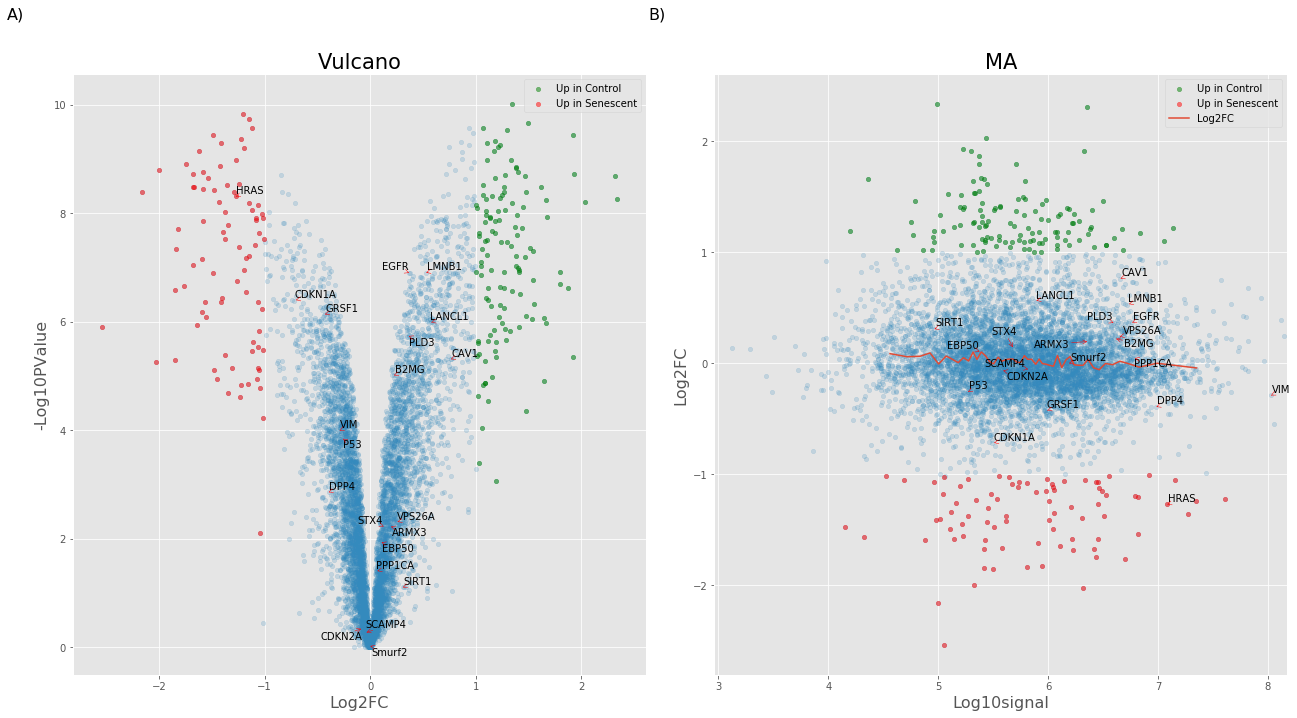

In [42]:
fig,axes=plt.subplots(figsize=(18,10), ncols=2, nrows=1)

make_vulcano(data_def, axes[0], x='Log2FC',y='-Log10PValue', 
             annot_index=_ids,
             annot_names = _names,
             title='Vulcano')

make_vulcano(data_def, axes[1], x='Log10signal', y='Log2FC', 
             annot_index=_ids,
             annot_names = _names,
             title='MA')

data_def.groupby('Log10signal_Q')[['Log10signal','Log2FC']].mean().plot(ax=axes[1],
                                                                        x='Log10signal',
                                                                        y='Log2FC')

axes[1].set_xlim(data_def['Log10signal'].min()-data_def['Log10signal'].min()*0.01,
                 data_def['Log10signal'].max()+data_def['Log10signal'].min()*0.01)

axes[0].title.set_size(21)
axes[1].title.set_size(21)
axes[0].yaxis.label.set_size(16)
axes[0].xaxis.label.set_size(16)
axes[1].yaxis.label.set_size(16)
axes[1].xaxis.label.set_size(16)
axes[0].text(-0.1, 1.1, 'A)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[0].transAxes,fontsize=16)

axes[1].text(-0.1, 1.1, 'B)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[1].transAxes,fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(TXT_PATH,'Fig_3_Senescence_markers.png'))
plt.show()

# Add Gene Ids

In [43]:
transcript_to_gene = {}
for n in open('mart_export_Human_genes_GRCh38.p1206062019.fasta'):
    if n.startswith('>'):
        #print (n)
        transcript_to_gene[n.split('|')[1]]=n.split('|')[0][1:]

data_def['transcript_id'] = [n.split('_')[1] for  n in data_def['Acc']]
data_def['gene_id'] = [transcript_to_gene[n] for  n in data_def['transcript_id']]

In [44]:
gene_to_desc = {}
for n in open('mart_export_gene_id_to_desc.txt'):
    #print(len(n.split('\t')))
    if len(n.split('\t'))==5:
        gene_to_desc[n.split('\t')[0]]=n.split('\t')[4].split('[')[0].strip()
    else:
        gene_to_desc[n.split('\t')[0]]='none'
data_def['desc'] = [gene_to_desc[n] if n in gene_to_desc else 'none'  for  n in data_def['gene_id'] ]

In [45]:
data_def.head()

,Acc,PValue,FDR,candidate,S1,S2,S3,C1,C2,C3,mean_s,mean_c,Log2FC,Log10signal,-Log10PValue,Log10signal_Q,transcript_id,gene_id,desc
index,,,,,,,,,,,,,,,,,,,
102,102_ENST00000373020_O43657__TSPAN6,0.618107,0.666770,no,8.533728e+05,1.258813e+06,1.296349e+06,1.055009e+06,1.055663e+06,1.059123e+06,1.136178e+06,1.056598e+06,-0.104762,6.340994,0.208936,39,ENST00000373020,ENSG00000000003,tetraspanin 6
103,103_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.160452,0.203621,no,1.059605e+06,1.194595e+06,1.169123e+06,1.085101e+06,1.083927e+06,1.085784e+06,1.141108e+06,1.084937e+06,-0.072823,6.347534,0.794656,40,ENST00000371588,ENSG00000000419,dolichyl-phosphate mannosyltransferase subunit...
104,104_ENST00000423670__X6RHX1_SCYL3,0.972037,0.977252,no,7.430159e+04,8.278515e+04,8.399583e+04,8.170924e+04,8.044888e+04,7.892759e+04,8.036086e+04,8.036190e+04,0.000019,5.206077,0.012317,9,ENST00000423670,ENSG00000000457,SCY1 like pseudokinase 3
105,105_ENST00000002165_Q9BTY2__FUCA2,0.000152,0.000526,high,5.509498e+05,6.037470e+05,6.187099e+05,7.490698e+05,7.757707e+05,7.453153e+05,5.911355e+05,7.567186e+05,0.356268,6.129643,3.818127,34,ENST00000002165,ENSG00000001036,alpha-L-fucosidase 2
106,106_ENST00000650454_P48506_Q14TF0_GCLC,0.164850,0.208356,no,1.028362e+06,1.271489e+06,1.301303e+06,1.087941e+06,1.091924e+06,1.083078e+06,1.200385e+06,1.087648e+06,-0.142285,6.359462,0.782911,40,ENST00000650454,ENSG00000001084,glutamate-cysteine ligase catalytic subunit


In [46]:
multy_transcripts = data_def['gene_id'].value_counts()[data_def['gene_id'].value_counts()>1]
gb = data_def.groupby('gene_id')
mean = gb['Log2FC'].mean().to_frame().reset_index()
std = gb['Log2FC'].std().to_frame().reset_index()
mean.columns=['gene_id', 'gene_mean']
std.columns=['gene_id', 'gene_std']
#std = gb['Log2FC'].std().to_frame()
#std.columns=['_std']

data_def=data_def.merge(mean, right_on='gene_id', left_on='gene_id')
#data_def=data_def.merge(std, right_on='gene_id', left_on='gene_id')
print(data_def.shape)
data_def.head()
#select = data_def[data_def['gene_id'].isin(multy_transcripts.index.values)].sort_values('transcript_std')[['Acc','Log2FC','Log10signal']]
#select = select.join(df[['Peptide counts (unique)']],how='left')
#select.tail(10)

(7496, 20)


,Acc,PValue,FDR,candidate,S1,S2,S3,C1,C2,C3,mean_s,mean_c,Log2FC,Log10signal,-Log10PValue,Log10signal_Q,transcript_id,gene_id,desc,gene_mean
0,102_ENST00000373020_O43657__TSPAN6,0.618107,0.666770,no,8.533728e+05,1.258813e+06,1.296349e+06,1.055009e+06,1.055663e+06,1.059123e+06,1.136178e+06,1.056598e+06,-0.104762,6.340994,0.208936,39,ENST00000373020,ENSG00000000003,tetraspanin 6,-0.104762
1,103_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.160452,0.203621,no,1.059605e+06,1.194595e+06,1.169123e+06,1.085101e+06,1.083927e+06,1.085784e+06,1.141108e+06,1.084937e+06,-0.072823,6.347534,0.794656,40,ENST00000371588,ENSG00000000419,dolichyl-phosphate mannosyltransferase subunit...,-0.072823
2,104_ENST00000423670__X6RHX1_SCYL3,0.972037,0.977252,no,7.430159e+04,8.278515e+04,8.399583e+04,8.170924e+04,8.044888e+04,7.892759e+04,8.036086e+04,8.036190e+04,0.000019,5.206077,0.012317,9,ENST00000423670,ENSG00000000457,SCY1 like pseudokinase 3,0.000019
3,105_ENST00000002165_Q9BTY2__FUCA2,0.000152,0.000526,high,5.509498e+05,6.037470e+05,6.187099e+05,7.490698e+05,7.757707e+05,7.453153e+05,5.911355e+05,7.567186e+05,0.356268,6.129643,3.818127,34,ENST00000002165,ENSG00000001036,alpha-L-fucosidase 2,0.356268
4,106_ENST00000650454_P48506_Q14TF0_GCLC,0.164850,0.208356,no,1.028362e+06,1.271489e+06,1.301303e+06,1.087941e+06,1.091924e+06,1.083078e+06,1.200385e+06,1.087648e+06,-0.142285,6.359462,0.782911,40,ENST00000650454,ENSG00000001084,glutamate-cysteine ligase catalytic subunit,-0.142285


In [47]:
data_def.shape

(7496, 20)

# Copy Number
[Return to the top](#Abstract)

## Histons selection

In [48]:

data_def['index'] = [int(n.split('_')[0]) for n in data_def['Acc']]
data_def= data_def.set_index('index',drop=True)

In [49]:
data_def.head()

,Acc,PValue,FDR,candidate,S1,S2,S3,C1,C2,C3,mean_s,mean_c,Log2FC,Log10signal,-Log10PValue,Log10signal_Q,transcript_id,gene_id,desc,gene_mean
index,,,,,,,,,,,,,,,,,,,,
102,102_ENST00000373020_O43657__TSPAN6,0.618107,0.666770,no,8.533728e+05,1.258813e+06,1.296349e+06,1.055009e+06,1.055663e+06,1.059123e+06,1.136178e+06,1.056598e+06,-0.104762,6.340994,0.208936,39,ENST00000373020,ENSG00000000003,tetraspanin 6,-0.104762
103,103_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.160452,0.203621,no,1.059605e+06,1.194595e+06,1.169123e+06,1.085101e+06,1.083927e+06,1.085784e+06,1.141108e+06,1.084937e+06,-0.072823,6.347534,0.794656,40,ENST00000371588,ENSG00000000419,dolichyl-phosphate mannosyltransferase subunit...,-0.072823
104,104_ENST00000423670__X6RHX1_SCYL3,0.972037,0.977252,no,7.430159e+04,8.278515e+04,8.399583e+04,8.170924e+04,8.044888e+04,7.892759e+04,8.036086e+04,8.036190e+04,0.000019,5.206077,0.012317,9,ENST00000423670,ENSG00000000457,SCY1 like pseudokinase 3,0.000019
105,105_ENST00000002165_Q9BTY2__FUCA2,0.000152,0.000526,high,5.509498e+05,6.037470e+05,6.187099e+05,7.490698e+05,7.757707e+05,7.453153e+05,5.911355e+05,7.567186e+05,0.356268,6.129643,3.818127,34,ENST00000002165,ENSG00000001036,alpha-L-fucosidase 2,0.356268
106,106_ENST00000650454_P48506_Q14TF0_GCLC,0.164850,0.208356,no,1.028362e+06,1.271489e+06,1.301303e+06,1.087941e+06,1.091924e+06,1.083078e+06,1.200385e+06,1.087648e+06,-0.142285,6.359462,0.782911,40,ENST00000650454,ENSG00000001084,glutamate-cysteine ligase catalytic subunit,-0.142285


In [50]:
from scipy.constants import Avogadro
from typing import List
def add_copy_number(df:pd.DataFrame, 
                    intensity_field:str, 
                    target_columns:List[str],
                    histons:List[int], 
                    mw_field:str,
                    )->'Protein Copy Number df':
    '''
    Implement the proteomic ruler defined in Wiśniewski JR et al, 2014. PMID: 25225357.
    The normalized TMT intenisty are used to compute the contribution of each channel
    to the Intensity column of MaxQuant. 
    copies = MS signal x Avogardo x dna Mass / molar mass / Histone Signal
    
    Assume 6.5 pg as the DNA mass of diploid human cells (Wiśniewski JR et al.)
    
    df: DataFrame with TMT intensity and Intensity columns
    intensity_field: name of MaxQuant Intensity column in df
    target_columns: names of TMT intensity columns
    histons: List of Histone proteins indexes in df
    mw_field: name of protein MW field in Kdalton (from MaxQuant)
    '''
    
    #sum of TMT channels
    target_sum = df[target_columns].sum(axis=1)
    #contribution of each TMT channel to the total signal
    target_frac = df[target_columns].div(target_sum, axis=0)
    del target_sum
    gc.collect()
    #conversion of TMT intensity to MaxQuant Intensity
    target_intensity = target_frac.multiply(df[intensity_field], axis=0)
    print('histons intensity percentage')
    print(target_intensity.loc[histons].sum()/target_intensity.sum()*100)
    #print(target_intensity.loc[histons].describe())
    
    #multiply by avogardo constant and weigth of human DNA in diploid cell
    temp = target_intensity*Avogadro*6.5e-12 #DNA in grams
    #Divide by MW in dalton
    temp = temp.div(df[mw_field]*1000, axis=0)
    #Divide by histone intensity
    temp = temp.div(target_intensity.loc[histons].sum(),axis=1)
    temp.columns = [n+'_copy_number' for n in temp.columns]
    print(temp.describe())
    return temp


In [51]:
#data_def.head()

In [52]:
#df.head()

In [53]:
print(data_def.shape, df.shape)
data_def = data_def.join(df[['Intensity', 'Mol. weight [kDa]']])
print(data_def.shape)
data_def.head()

(7496, 20) (7496, 104)
(7496, 22)


,Acc,PValue,FDR,candidate,S1,S2,S3,C1,C2,C3,...,Log2FC,Log10signal,-Log10PValue,Log10signal_Q,transcript_id,gene_id,desc,gene_mean,Intensity,Mol. weight [kDa]
index,,,,,,,,,,,,,,,,,,,,,
102,102_ENST00000373020_O43657__TSPAN6,0.618107,0.666770,no,8.533728e+05,1.258813e+06,1.296349e+06,1.055009e+06,1.055663e+06,1.059123e+06,...,-0.104762,6.340994,0.208936,39,ENST00000373020,ENSG00000000003,tetraspanin 6,-0.104762,2593700000,27.563
103,103_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.160452,0.203621,no,1.059605e+06,1.194595e+06,1.169123e+06,1.085101e+06,1.083927e+06,1.085784e+06,...,-0.072823,6.347534,0.794656,40,ENST00000371588,ENSG00000000419,dolichyl-phosphate mannosyltransferase subunit...,-0.072823,5562800000,29.634
104,104_ENST00000423670__X6RHX1_SCYL3,0.972037,0.977252,no,7.430159e+04,8.278515e+04,8.399583e+04,8.170924e+04,8.044888e+04,7.892759e+04,...,0.000019,5.206077,0.012317,9,ENST00000423670,ENSG00000000457,SCY1 like pseudokinase 3,0.000019,104740000,65.298
105,105_ENST00000002165_Q9BTY2__FUCA2,0.000152,0.000526,high,5.509498e+05,6.037470e+05,6.187099e+05,7.490698e+05,7.757707e+05,7.453153e+05,...,0.356268,6.129643,3.818127,34,ENST00000002165,ENSG00000001036,alpha-L-fucosidase 2,0.356268,1711300000,54.066
106,106_ENST00000650454_P48506_Q14TF0_GCLC,0.164850,0.208356,no,1.028362e+06,1.271489e+06,1.301303e+06,1.087941e+06,1.091924e+06,1.083078e+06,...,-0.142285,6.359462,0.782911,40,ENST00000650454,ENSG00000001084,glutamate-cysteine ligase catalytic subunit,-0.142285,2715300000,72.765


In [54]:
#add histone index
_ids = []
_names = []
for gene_id, gene_name in zip(histones_df['genes'],histones_df['names']):
    res_ids =list(df[df['Fasta headers'].str.contains(gene_id)].index.values)
    if len(res_ids)>0:
        _ids+=res_ids
        _names += [gene_name]*len(res_ids)
print(len(_ids))
print(len(_names))

10
10


histons intensity percentage
S1    0.623349
S2    0.704038
S3    0.729475
C1    0.962981
C2    0.907384
C3    0.909127
dtype: float64
       S1_copy_number  S2_copy_number  S3_copy_number  C1_copy_number  \
count    7.496000e+03    7.496000e+03    7.496000e+03    7.496000e+03   
mean     1.998853e+06    1.768393e+06    1.706514e+06    1.287390e+06   
std      1.153078e+07    9.906500e+06    9.577680e+06    7.556432e+06   
min      0.000000e+00    0.000000e+00    0.000000e+00    8.946190e+01   
25%      2.946801e+04    2.828598e+04    2.771265e+04    2.093433e+04   
50%      1.358236e+05    1.257744e+05    1.226494e+05    9.155344e+04   
75%      6.805069e+05    6.260360e+05    6.075148e+05    4.575003e+05   
max      4.575602e+08    3.794574e+08    3.697750e+08    2.780516e+08   

       C2_copy_number  C3_copy_number  
count    7.496000e+03    7.496000e+03  
mean     1.365043e+06    1.366082e+06  
std      8.106192e+06    8.057556e+06  
min      1.061852e+02    1.169158e+02  
25%     

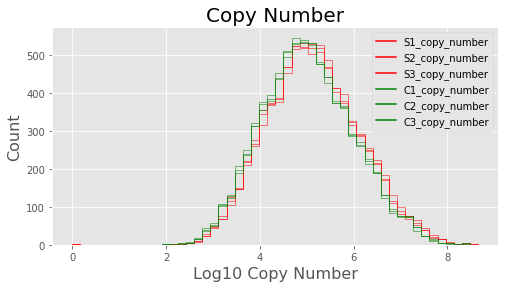

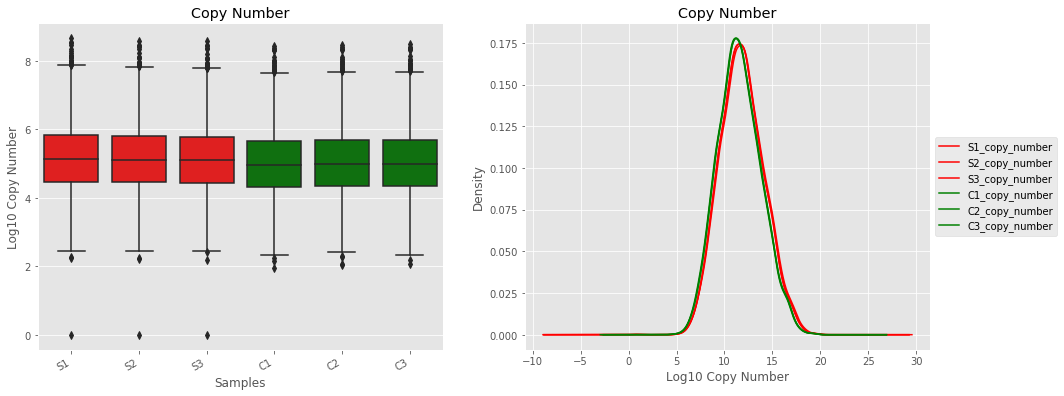

In [55]:
intensity_field = ['Intensity']
mw_field = 'Mol. weight [kDa]'

target_columns = ['S1','S2','S3','C1','C2','C3']

cn = add_copy_number(df=data_def, intensity_field='Intensity',
                target_columns = target_columns,
                histons=_ids, mw_field=mw_field)
fig,ax=plt.subplots(figsize=(8,4))
np.log10(cn+1).plot(kind='hist', histtype='step',ax=ax, bins=50,color=['r','r','r','g','g','g'])
ax.set_xlabel('Log10 Copy Number',fontsize=16)
ax.set_ylabel('Count', fontsize=16)
hist_legend(ax)
plt.title('Copy Number', fontsize=20)
plt.show()
#cn['genes']=data_def['Acc']
#cn.head()

fig,axes=plt.subplots(figsize=(16,6),ncols=2,nrows=1)
sns.boxplot(data=np.log10(cn+1), ax=axes[0],palette=exp_palette)
axes[0].set_xticklabels(data.columns, rotation=30, ha='right')
axes[0].set_title('Copy Number')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Log10 Copy Number')


np.log1p(cn+1).plot(kind='kde',ax=axes[1],color=exp_palette)
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].set_title('Copy Number')
axes[1].set_xlabel('Log10 Copy Number')
plt.show()

In [56]:
cn.head()

,S1_copy_number,S2_copy_number,S3_copy_number,C1_copy_number,C2_copy_number,C3_copy_number
index,,,,,,
102,7.048512e+05,9.367486e+05,9.318358e+05,5.741778e+05,6.074069e+05,6.091225e+05
103,1.719780e+06,1.746839e+06,1.651384e+06,1.160461e+06,1.225532e+06,1.227078e+06
104,1.427227e+04,1.432685e+04,1.404144e+04,1.034184e+04,1.076492e+04,1.055658e+04
105,2.490180e+05,2.458539e+05,2.433687e+05,2.230862e+05,2.442574e+05,2.345623e+05
106,3.228040e+05,3.595911e+05,3.554921e+05,2.250246e+05,2.387707e+05,2.367293e+05


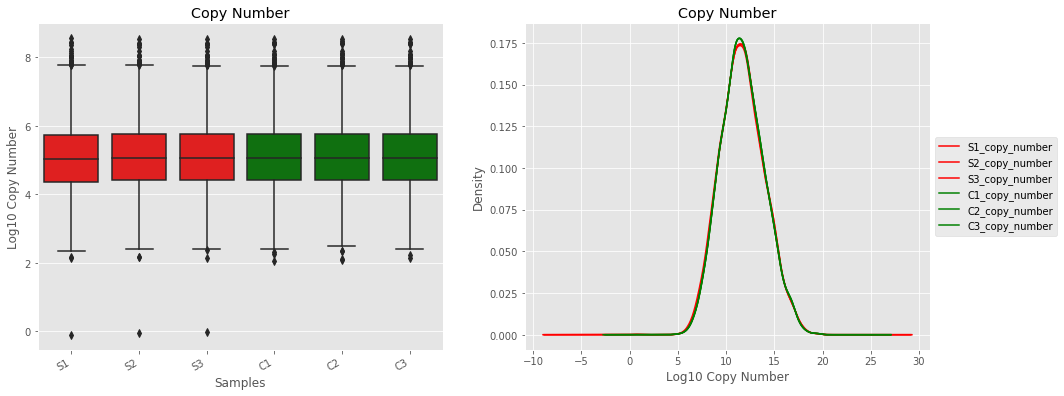

In [57]:
#we create normalization factors based on the average sum intensity of each channel
cn=cn+1
col_sum = cn.sum(axis=0)
target = np.mean(col_sum)
norm_facs = target / col_sum
cn_norm = cn.multiply(norm_facs, axis=1)

fig,axes=plt.subplots(figsize=(16,6),ncols=2,nrows=1)
sns.boxplot(data=np.log10(cn_norm), ax=axes[0],palette=exp_palette)
axes[0].set_xticklabels(data.columns, rotation=30, ha='right')
axes[0].set_title('Copy Number')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Log10 Copy Number')


np.log1p(cn_norm).plot(kind='kde',ax=axes[1],color=exp_palette)
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].set_title('Copy Number')
axes[1].set_xlabel('Log10 Copy Number')
plt.show()

In [58]:
#data_def.head()

In [59]:
cn_norm['genes']=data_def['Acc'].values

In [60]:
%%R -i cn_norm
accession <- cn_norm$'genes'
limma_data = within(cn_norm, rm('genes'))

In [61]:
%R head(limma_data)

,S1_copy_number,S2_copy_number,S3_copy_number,C1_copy_number,C2_copy_number,C3_copy_number
102,5.578742e+05,8.380381e+05,8.638715e+05,7.055959e+05,7.039683e+05,7.054198e+05
103,1.361167e+06,1.562764e+06,1.530938e+06,1.426067e+06,1.420358e+06,1.421067e+06
104,1.129697e+04,1.281803e+04,1.301823e+04,1.271010e+04,1.247739e+04,1.222663e+04
105,1.970928e+05,2.199475e+05,2.256190e+05,2.741471e+05,2.830885e+05,2.716454e+05
106,2.554927e+05,3.216995e+05,3.295645e+05,2.765291e+05,2.767295e+05,2.741550e+05
107,1.325915e+05,1.363747e+05,1.360969e+05,1.229816e+05,1.195867e+05,1.176545e+05


In [62]:
%%R
row.names(limma_data) <- accession # add accessions as row names
# set up the design matrix
group <- as.factor(c(rep("senescent", 3), rep("control", 3)))
group <- factor(group, levels(group)[c(2, 1)]) # set the factor order
design <- model.matrix(~ 0 + group)
colnames(design) <- c("senescent", "control")

# make the contrast
contrast <- makeContrasts(senescent-control, levels = design)

S <- 1:3
C <- 4:6
# do the linear model fitting on log2 values
limma_log_data <- log2(limma_data[c(S, C)])
fit <- lmFit(limma_log_data, design)

# get the fit for the contrast of interest
fit2 <- contrasts.fit(fit, contrast)

# do the empirical Bayes moderation of the test statistic (with trended variance)
fit2 <- eBayes(fit2, trend = TRUE)

# grab the information in topTable so we can get the data to plot candidates
# the coef parameter has to do with the contrast of interest
# specify no sorting of results and a number that is longer than the data table
tt_limma <- topTable(fit2, coef = 1, sort.by = "none", number = Inf)


In [63]:
%R topTable(fit2)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
789_ENST00000506438_P78337_X5D9A5_PITX1,-9.515879,4.555510,-83.038783,5.996359e-11,4.494871e-07,15.726547
403_ENST00000037243_P60520__GABARAPL2,-1.356509,21.555588,-71.433130,1.569984e-10,5.558287e-07,15.001484
8373_ENST00000395564_Q16831__UPP1,1.479294,18.023023,62.599204,3.650224e-10,5.558287e-07,14.306392
2505_ENST00000456829_O00534_A0A024R3H3_VWA5A,1.194082,20.567008,61.524979,4.077146e-10,5.558287e-07,14.211464
3848_ENST00000382263_Q9NS68__TNFRSF19,-1.391092,17.301789,-61.043963,4.286846e-10,5.558287e-07,14.168143
7179_ENST00000593998_Q9BY76__ANGPTL4,1.610645,18.695988,60.690287,4.449002e-10,5.558287e-07,14.135963
274_ENST00000552962_P07585_Q6FH10_DCN,-1.302416,18.801835,-57.768071,6.098060e-10,5.608822e-07,13.858998
1765_ENST00000398411_P01034_A0A0K0K1J1_CST3,1.413990,18.679357,57.596923,6.214755e-10,5.608822e-07,13.842140
2679_ENST00000419835__J3KQ69_MCM3,-1.508485,15.822670,-56.877761,6.734179e-10,5.608822e-07,13.770499
6827_ENST00000330295_Q96CG8__CTHRC1,-1.343291,19.982806,-55.924864,7.501673e-10,5.623254e-07,13.673532


In [64]:
%%R
# statisticl test results
limma_data$Acc <- accession
limma_data$PValue <- tt_limma$P.Value
limma_data$FDR <- tt_limma$adj.P.Val
head(limma_data)
# add a DE candidate status column
limma_data$candidate <- cut(limma_data$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                           labels = c("high", "med", "low", "no"))


In [65]:
%R head(limma_data)

,S1_copy_number,S2_copy_number,S3_copy_number,C1_copy_number,C2_copy_number,C3_copy_number,Acc,PValue,FDR,candidate
102_ENST00000373020_O43657__TSPAN6,5.578742e+05,8.380381e+05,8.638715e+05,7.055959e+05,7.039683e+05,7.054198e+05,102_ENST00000373020_O43657__TSPAN6,0.686850,0.735519,no
103_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,1.361167e+06,1.562764e+06,1.530938e+06,1.426067e+06,1.420358e+06,1.421067e+06,103_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.296883,0.357557,no
104_ENST00000423670__X6RHX1_SCYL3,1.129697e+04,1.281803e+04,1.301823e+04,1.271010e+04,1.247739e+04,1.222663e+04,104_ENST00000423670__X6RHX1_SCYL3,0.832465,0.861662,no
105_ENST00000002165_Q9BTY2__FUCA2,1.970928e+05,2.199475e+05,2.256190e+05,2.741471e+05,2.830885e+05,2.716454e+05,105_ENST00000002165_Q9BTY2__FUCA2,0.000347,0.001154,high
106_ENST00000650454_P48506_Q14TF0_GCLC,2.554927e+05,3.216995e+05,3.295645e+05,2.765291e+05,2.767295e+05,2.741550e+05,106_ENST00000650454_P48506_Q14TF0_GCLC,0.239683,0.295455,no
107_ENST00000374807_Q9Y4W2__LAS1L,1.325915e+05,1.363747e+05,1.360969e+05,1.229816e+05,1.195867e+05,1.176545e+05,107_ENST00000374807_Q9Y4W2__LAS1L,0.000839,0.002332,high


In [66]:
%R -o limma_data

In [67]:
cn = pd.DataFrame(limma_data)
cn['index']=[int(n.split('_')[0]) for n in cn['Acc']]
cn.set_index('index',inplace=True,drop=True)

In [68]:
cn.head()

,S1_copy_number,S2_copy_number,S3_copy_number,C1_copy_number,C2_copy_number,C3_copy_number,Acc,PValue,FDR,candidate
index,,,,,,,,,,
102,5.578742e+05,8.380381e+05,8.638715e+05,7.055959e+05,7.039683e+05,7.054198e+05,102_ENST00000373020_O43657__TSPAN6,0.686850,0.735519,no
103,1.361167e+06,1.562764e+06,1.530938e+06,1.426067e+06,1.420358e+06,1.421067e+06,103_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.296883,0.357557,no
104,1.129697e+04,1.281803e+04,1.301823e+04,1.271010e+04,1.247739e+04,1.222663e+04,104_ENST00000423670__X6RHX1_SCYL3,0.832465,0.861662,no
105,1.970928e+05,2.199475e+05,2.256190e+05,2.741471e+05,2.830885e+05,2.716454e+05,105_ENST00000002165_Q9BTY2__FUCA2,0.000347,0.001154,high
106,2.554927e+05,3.216995e+05,3.295645e+05,2.765291e+05,2.767295e+05,2.741550e+05,106_ENST00000650454_P48506_Q14TF0_GCLC,0.239683,0.295455,no


In [69]:
for n in ['S1_copy_number','S2_copy_number','S3_copy_number',
          'C1_copy_number','C2_copy_number','C3_copy_number']:
    cn[n]=cn[n].astype(int)

In [70]:
#add some values for plotting results
cn['mean_s_copy_number'] = cn[[n+'_copy_number' for n in ['S1','S2','S3']]].mean(axis=1)
cn['mean_c_copy_number'] = cn[[n+'_copy_number' for n in ['C1','C2','C3']]].mean(axis=1)
cn['Log2FC'] = np.log2(cn['mean_c_copy_number']/cn['mean_s_copy_number'])
cn['Log10signal_copy_number'] = np.log10(cn['mean_c_copy_number']+cn['mean_s_copy_number'])
cn['-Log10PValue_copy_number'] = -np.log10(cn['PValue'])
cn['Log10signal_Q_copy_number'] = pd.qcut(cn['Log10signal_copy_number'], 50, range(50))

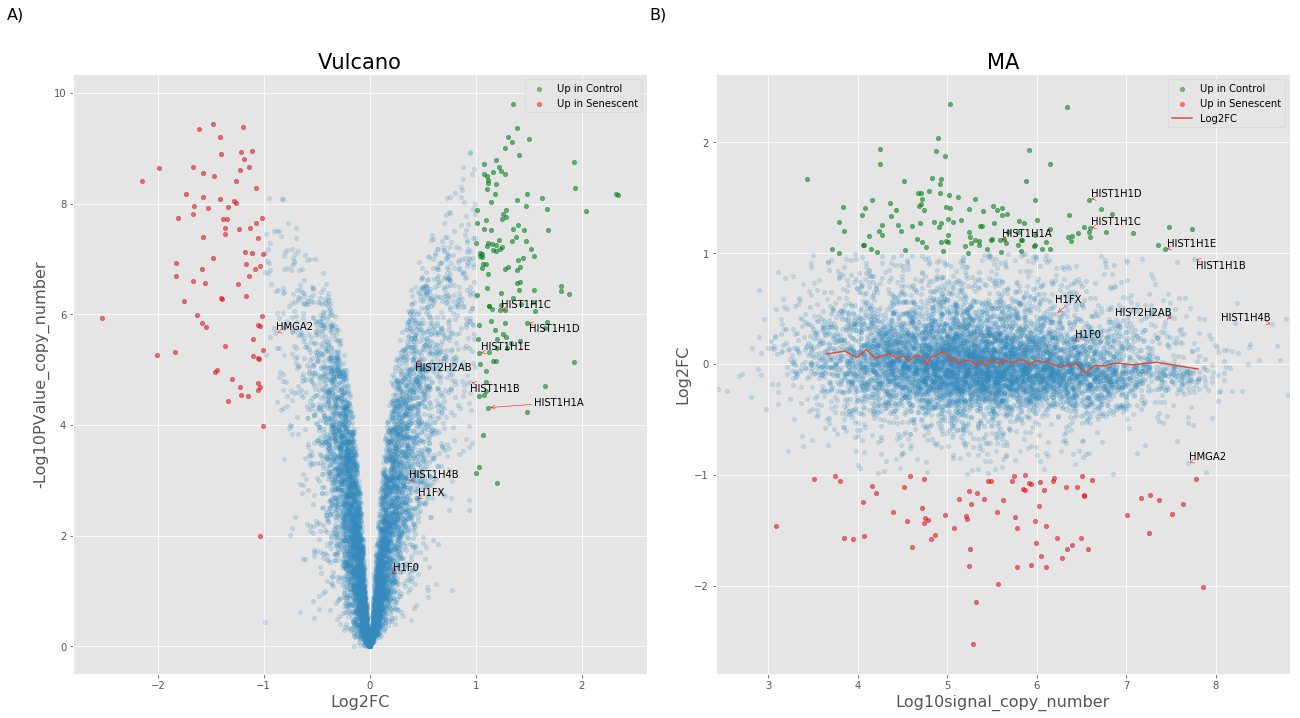

In [71]:
x_ma = 'Log10signal_copy_number'
y_ma = 'Log2FC'
group_ma = 'Log10signal_Q_copy_number'

x_vulcano = 'Log2FC'
y_vulcano = '-Log10PValue_copy_number'



fig,axes=plt.subplots(figsize=(18,10), ncols=2, nrows=1)

make_vulcano(cn, axes[0], x=x_vulcano,y=y_vulcano, 
             annot_index=_ids,
             annot_names = _names,
             title='Vulcano')

make_vulcano(cn, axes[1], x=x_ma, y=y_ma, 
             annot_index=_ids,
             annot_names = _names,
             title='MA')

cn.groupby(group_ma)[[x_ma,y_ma]].mean().plot(ax=axes[1], x=x_ma,y=y_ma)

axes[1].set_xlim(cn[x_ma].min()-cn[x_ma].min()*0.01,
                 cn[x_ma].max()+cn[x_ma].min()*0.01)

axes[0].title.set_size(21)
axes[1].title.set_size(21)
axes[0].yaxis.label.set_size(16)
axes[0].xaxis.label.set_size(16)
axes[1].yaxis.label.set_size(16)
axes[1].xaxis.label.set_size(16)
axes[0].text(-0.1, 1.1, 'A)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[0].transAxes,fontsize=16)

axes[1].text(-0.1, 1.1, 'B)', horizontalalignment='center', 
               verticalalignment='center',
               transform=axes[1].transAxes,fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(TXT_PATH,'Fig_4_Histones_cn.png'))
plt.show()

In [72]:
cn.columns=[n if '_copy_number' in n else n+'_copy_number' for n in cn.columns]

In [73]:
cn.head()

,S1_copy_number,S2_copy_number,S3_copy_number,C1_copy_number,C2_copy_number,C3_copy_number,Acc_copy_number,PValue_copy_number,FDR_copy_number,candidate_copy_number,mean_s_copy_number,mean_c_copy_number,Log2FC_copy_number,Log10signal_copy_number,-Log10PValue_copy_number,Log10signal_Q_copy_number
index,,,,,,,,,,,,,,,,
102,557874,838038,863871,705595,703968,705419,102_ENST00000373020_O43657__TSPAN6,0.686850,0.735519,no,7.532610e+05,7.049940e+05,-0.095539,6.163833,0.163138,39
103,1361166,1562764,1530938,1426067,1420357,1421067,103_ENST00000371588_O60762_A0A0S2Z4Y5_DPM1,0.296883,0.357557,no,1.484956e+06,1.422497e+06,-0.061995,6.463513,0.527415,42
104,11296,12818,13018,12710,12477,12226,104_ENST00000423670__X6RHX1_SCYL3,0.832465,0.861662,no,1.237733e+04,1.247100e+04,0.010877,4.395297,0.079634,8
105,197092,219947,225619,274147,283088,271645,105_ENST00000002165_Q9BTY2__FUCA2,0.000347,0.001154,high,2.142193e+05,2.762933e+05,0.367112,5.690650,3.459859,31
106,255492,321699,329564,276529,276729,274154,106_ENST00000650454_P48506_Q14TF0_GCLC,0.239683,0.295455,no,3.022517e+05,2.758040e+05,-0.132107,5.761970,0.620363,32


In [74]:
cols = ['S1_copy_number',
        'S2_copy_number',
        'S3_copy_number',
        'C1_copy_number',
        'C2_copy_number',
        'C3_copy_number',
        'mean_s_copy_number',
        'mean_c_copy_number']
for c in cols:
    cn[c] =  cn[c].astype(int)

data_def = data_def.join(cn[cols])

In [75]:
col_to_use = '''transcript_id
gene_id
desc
S1
S2
S3
C1
C2
C3
mean_s
mean_c
PValue
Log2FC
Log10signal
-Log10PValue
Intensity
Mol. weight [kDa]
S1_copy_number
S2_copy_number
S3_copy_number
C1_copy_number
C2_copy_number
C3_copy_number
mean_s_copy_number
mean_c_copy_number'''
temp = data_def[col_to_use.split('\n')]
temp.rename({'-Log10PValue':'#-Log10PValue'},axis=1)
temp.to_csv(os.path.join(TXT_PATH,'data_def.csv'))

In [76]:
cn['transcript_id'] = [n.split('_')[1] for  n in cn['Acc_copy_number']]
cn['gene_id'] = [transcript_to_gene[n] for  n in cn['transcript_id']]

In [77]:
rna = pd.read_csv('IMR90iRasPos_Vs_IMR90RasNeg.csv')
rna['gene_id']=rna['Row.names']
rna.set_index('gene_id', inplace=True,drop=True)
rna['rna_Log2FC']=rna['log2FoldChange']*-1
rna.head()

,Row.names,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Associated.Gene.Name,rna_Log2FC
gene_id,,,,,,,,,
ENSG00000072041,ENSG00000072041,3694.228605,3.859109,0.055265,69.829322,0.0,0.0,SLC6A15,-3.859109
ENSG00000085117,ENSG00000085117,3598.241821,2.768068,0.063402,43.659300,0.0,0.0,CD82,-2.768068
ENSG00000108932,ENSG00000108932,2148.510407,6.717515,0.164190,40.912945,0.0,0.0,SLC16A6,-6.717515
ENSG00000115919,ENSG00000115919,330.176513,5.006367,0.120859,41.423075,0.0,0.0,KYNU,-5.006367
ENSG00000116729,ENSG00000116729,17036.347468,2.854130,0.033170,86.044323,0.0,0.0,WLS,-2.854130


In [78]:
#markers_df.head()

In [79]:
#fig,ax=plt.subplots(figsize=(16,8))
#rna['log10baseMean']=np.log10(rna['baseMean'])
#rna.plot(kind='scatter',x='log10baseMean',y='log2FoldChange',ax=ax)
#rna.loc[markers_df.genes].plot(kind='scatter',x='log10baseMean',y='log2FoldChange',c='r',ax=ax)
#plt.show()

In [80]:
temp_cn = cn[['gene_id','Log2FC_copy_number']]
temp_cn = temp_cn.groupby('gene_id').mean()
temp_cn.columns = ['cn_Log2FC']
temp_cn.head()

,cn_Log2FC
gene_id,
ENSG00000000003,-0.095539
ENSG00000000419,-0.061995
ENSG00000000457,0.010877
ENSG00000001036,0.367112
ENSG00000001084,-0.132107


In [81]:
temp_tmt = data_def[['gene_id','Log2FC']]
#temp_tmt['gene_id']=[res[n] for n in temp_tmt['gene_id']]
temp_tmt = temp_tmt.groupby('gene_id').mean()
temp_tmt.columns = ['tmt_Log2FC']
temp_tmt.head()

,tmt_Log2FC
gene_id,
ENSG00000000003,-0.104762
ENSG00000000419,-0.072823
ENSG00000000457,0.000019
ENSG00000001036,0.356268
ENSG00000001084,-0.142285


In [82]:
merge = pd.concat([temp_tmt,temp_cn,rna[['rna_Log2FC','Associated.Gene.Name']]],axis=1)
merge = merge.dropna()
print(merge.shape)
merge.head()


(7167, 4)


,tmt_Log2FC,cn_Log2FC,rna_Log2FC,Associated.Gene.Name
ENSG00000000003,-0.104762,-0.095539,-0.504799,TSPAN6
ENSG00000000419,-0.072823,-0.061995,-0.268469,DPM1
ENSG00000000457,0.000019,0.010877,-0.110320,SCYL3
ENSG00000001036,0.356268,0.367112,0.138455,FUCA2
ENSG00000001084,-0.142285,-0.132107,-1.281091,GCLC


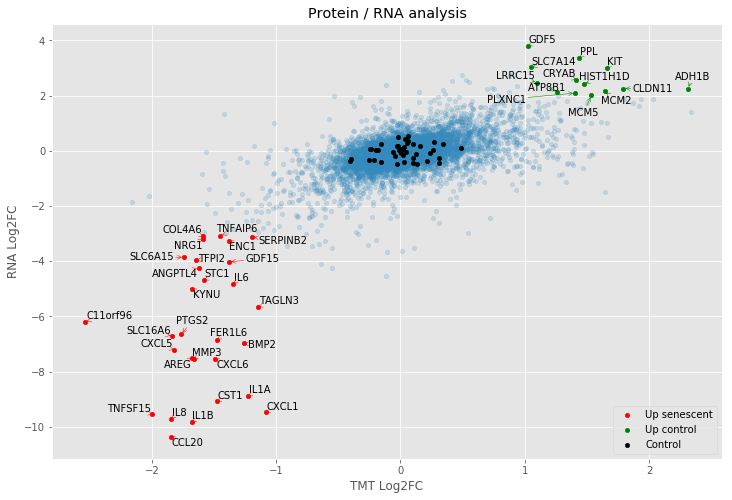

In [83]:
fig,ax=plt.subplots(figsize=(12,8))
x= 'tmt_Log2FC'
y = 'rna_Log2FC'
merge.plot(kind='scatter',x=x, y=y, alpha=0.2, ax=ax)

temp = merge[ (merge[x]<-1) & (merge[y]<-3)]
temp = temp.dropna()
temp.plot(kind='scatter',x=x, y=y, c='r', ax=ax,label='Up senescent')

texts = [ ax.text(merge.loc[i][x], merge.loc[i][y], 
                  merge.loc[i]['Associated.Gene.Name'])
                       for i in temp.index.values ]
adjust_text(texts, arrowprops=dict(arrowstyle='->',
                                       color='red'),
                ax=ax)

temp = merge[ (merge[x]>1) & (merge[y]>2)]
temp = temp.dropna()
temp.plot(kind='scatter',x=x, y=y, c='g', ax=ax, label='Up control')

texts = [ ax.text(merge.loc[i][x], merge.loc[i][y], 
                  merge.loc[i]['Associated.Gene.Name'])
                       for i in temp.index.values ]
adjust_text(texts, arrowprops=dict(arrowstyle='->',
                                       color='green'),
                ax=ax)

#Figure 2 #PMID: 30710410
'''ENSG00000244045 TMEM199
ENSG00000124333 VAMP7
ENSG00000198945 L3MBTL3
ENSG00000120314 WDR55
ENSG00000089157 RPLP0
ENSG00000075624 ACTB
ENSG00000111640 GAPDH
ENSG00000125826 RBCK1
ENSG00000035403 VCL
ENSG00000167552 TUBA1A'''

#Table S3 #PMID: 30710410
control_long = '''ENSG00000244045
ENSG00000120314
ENSG00000125826
ENSG00000100395
ENSG00000124333
ENSG00000172888
ENSG00000123415
ENSG00000168096
ENSG00000138279
ENSG00000123268
ENSG00000125166
ENSG00000151292
ENSG00000135930
ENSG00000198690
ENSG00000066135
ENSG00000121022
ENSG00000139651
ENSG00000152219
ENSG00000110711
ENSG00000145439
ENSG00000197302
ENSG00000185909
ENSG00000122912
ENSG00000177370
ENSG00000164169
ENSG00000132768
ENSG00000188636
ENSG00000095261
ENSG00000163866
ENSG00000159579
ENSG00000100319
ENSG00000103091
ENSG00000165630
ENSG00000169696
ENSG00000162642
ENSG00000134825
ENSG00000163512
ENSG00000143486
ENSG00000068308
ENSG00000120159
ENSG00000166170
ENSG00000118197
ENSG00000145916
ENSG00000164022
ENSG00000221909
ENSG00000133313
ENSG00000127993
ENSG00000121542
ENSG00000109113
ENSG00000163684
ENSG00000135823
ENSG00000166579
ENSG00000164091
ENSG00000162227
ENSG00000103248
ENSG00000168827
ENSG00000204231
ENSG00000154144
ENSG00000152082
ENSG00000120805
ENSG00000111725
ENSG00000167716
ENSG00000151092
ENSG00000123124
ENSG00000148399'''.split('\n')


control = ['ENSG00000244045','ENSG00000124333','ENSG00000198945','ENSG00000120314',
'ENSG00000089157','ENSG00000075624','ENSG00000075624','ENSG00000111640',
'ENSG00000125826','ENSG00000125826','ENSG00000035403','ENSG00000167552']


merge.loc[control_long].plot(kind='scatter', x=x, y=y, c='k', ax=ax,label='Control')

#texts = [ ax.text(merge.loc[i][x], merge.loc[i][y], 
#                  merge.loc[i]['Associated.Gene.Name'])
#                       for i in control]
#adjust_text(texts, arrowprops=dict(arrowstyle='->',
#                                      color='k'),
#                ax=ax)
plt.legend(loc="lower right")
ax.set_xlabel('TMT Log2FC')
ax.set_ylabel('RNA Log2FC')

plt.title('Protein / RNA analysis')
plt.savefig(os.path.join(TXT_PATH,'Fig_5_RNA_PROT.png'))
plt.show()

In [84]:
from sklearn.linear_model import HuberRegressor,Ridge
huber = HuberRegressor(epsilon=50).fit(merge[[x]], merge[y])
print(huber.score(merge[[x]], merge[y]))
ridge = Ridge(alpha=20).fit(merge[[x]], merge[y])
print(ridge.score(merge[[x]], merge[y]))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\michele\miniconda3\envs\prediction\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-84-85f79705d4de>", line 2, in <module>
    huber = HuberRegressor(epsilon=50).fit(merge[[x]], merge[y])
  File "D:\michele\miniconda3\envs\prediction\lib\site-packages\sklearn\linear_model\huber.py", line 255, in fit
    X, y, copy=False, accept_sparse=['csr'], y_numeric=True)
  File "D:\michele\miniconda3\envs\prediction\lib\site-packages\sklearn\utils\validation.py", line 756, in check_X_y
    estimator=estimator)
  File "D:\michele\miniconda3\envs\prediction\lib\site-packages\sklearn\utils\validation.py", line 573, in check_array
    allow_nan=force_all_finite == 'allow-nan')
  File "D:\michele\miniconda3\envs\prediction\lib\site-packages\sklearn\utils\validation.py", line 56, in _assert_all_finite
    raise ValueError(msg_err.format(type_err, X.dtype))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
protein_complex = pd.read_table('homo_sapiens_interactions.tsv')
col = 'Identifiers (and stoichiometry) of molecules in complex'
protein_complex = protein_complex[~protein_complex[col].str.contains('(0)')]
protein_complex['components'] = [len(n.split('|')) for n in protein_complex[col]]
protein_complex=protein_complex[protein_complex['components']>1]
print(protein_complex.shape)

ids = []
ste = []
for pcomplex in protein_complex[col]:
    components = pcomplex.split('|')
    ids .append([n.split('(')[0] for n in components])
    ste.append([int(n.split('(')[1].replace(')','')) for n in components])

protein_complex['ids']=ids
protein_complex['ste']=ste

In [ ]:
res = []
for items in protein_complex['ids']:
    temp = []
    for prot in items:
        temp.append(df['Fasta headers'].str.contains(prot).sum())
    res.append(sum(temp))
protein_complex['in_dataset']=res

In [ ]:
protein_complex = protein_complex[protein_complex['components']==protein_complex['in_dataset']]
cols = ['#Complex ac','Recommended name','components','in_dataset','ids','ste']
print(protein_complex.shape)
protein_complex[cols]